# Question 1 (Detailed walkthrough after answers)

---

#### a). Think about what could be going wrong with our calculation. Think about a better way to evaluate this data.

As we explored our order data, we realized that we only had a handful of orders that were extremely high compared to the rest and upon further investigation, this erronousness was found to be basically for two reasons:
- Shops having unusually high number of items per order (possibly bulk/wholesale buying)
- Shops having unusually high selling price per item (possibly luxury brand)

We found out that primarily, shops 42 and 78 were involved in skewing our data where shop 42 fell in the first category where it had a few orders with extremely `total_items` per order which when multiplied with a reasonable selling price of a shoe gave us very high `order_amount`s. On the other hand, we found shop 72 to exhibit the second type of erronousness where even though its had number of items similar to all other shops, its selling price per unit was incredibly high which skewed our data with high `order_amount`s.

It is entirely possible that as we scale our operations, we might encounter more stores with such characteristics or a combination of them as well.

As we want some analysis on our sales, an average order value (AOV) metric serves the purpose well, however, it needs to be calculated by removing our outlying orders that might give us unusally high (or even unusually low figures as a future update to this analysis as we increase in scale). 

However, we also must make sure we cannot simply discount entire shops due to certain characteristics, for example, we cannot directly ignore shop 78's contributions to sales due to its high selling price per sneaker. Hence, we should rather take a more holistic approach to calculating our AOV that is blind to exact parameters and is more robust for usage of new data and changes in sales patterns.

Therefore, a better way of evaulating this data and calculating our AOV metric would be much better if we remove and filter out certain outlying orders from consideration to prevent such abnormalities from affecting the general sales/order trends that we observe.


#### b). What metric would you report for this dataset?

To do some analysis of average order value (AOV), the simple metric of taking the mean of `order_amount`s should work fine. However, we should make sure to remove some outliers from our data before calculating our metric.

Through our analyses, we found that removing the top 2% of our orders with unusually high `order_amount`s and `total_items` leaves us with a dataset that is clean enough for un-skewed and unbiased analysis and is more representative of all our shops' orders. This would make sure unusually high order sizes or unusually high prices prevent our entire analysis from being skewed in a particular direction while being mindful of not manually ignoring specific parameters.

Moreover, with a growing data set, we can think of the law of averages where the bulk of data would always tend to approach a certain mean which helps us clear viability of removing such outlying data.

As an update for scalability, we can also appropriately remove the bottom 2% of such orders as well in future versions. Moreover, based on growth, this limit of top/bottom 2% can also be adjusted to better suit business trends, however, in the curretn scenario it works appropriately.

Therefore, based on current trends, we could continue using the average order value (AOV) as a metric for analysing sales. However, we should be adopting a practice of removing the top 2% of our orders before calculating the mean AOV of `order_amount` as our reporting metric.

#### c). What is its value?

Our new metric of trimmed average order value gives us an $AOV_{trimmed} = \$293.06.$

This is much more representative of our total orders and should be considered for our analysis.

# Detailed walkthrough:

---

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [4]:
df = pd.read_csv("data.csv")
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   order_id        5000 non-null   int64 
 1   shop_id         5000 non-null   int64 
 2   user_id         5000 non-null   int64 
 3   order_amount    5000 non-null   int64 
 4   total_items     5000 non-null   int64 
 5   payment_method  5000 non-null   object
 6   created_at      5000 non-null   object
dtypes: int64(5), object(2)
memory usage: 273.6+ KB


,order_id,shop_id,user_id,order_amount,total_items
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000
mean,2500.500000,50.078800,849.092400,3145.128000,8.78720
std,1443.520003,29.006118,87.798982,41282.539349,116.32032
min,1.000000,1.000000,607.000000,90.000000,1.00000
25%,1250.750000,24.000000,775.000000,163.000000,1.00000
50%,2500.500000,50.000000,849.000000,284.000000,2.00000
75%,3750.250000,75.000000,925.000000,390.000000,3.00000
max,5000.000000,100.000000,999.000000,704000.000000,2000.00000


# 1a. Better way to evalulate data
## Cause for suspicion

From a general summary of our data, we can see that we have something fishy going on. For our columns `order_amount` and `total_items`, we can see that the standard devation amounts are significantly high. For each of their respective means, we can see that the maximum value for both these columns are significantly higher than its quantiles/median.
 
Hence, we can say that our direct mean order amount that is currently being used as our key AOV metric is skewed.

However, let us find further relationship betwen the order amounts and the total number of items in an order as a higher order amount may be attributed to an unusally high number of items.

In [5]:
df.sort_values(by=['order_amount', 'total_items'], inplace=True, ascending=False)
df

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
15,16,42,607,704000,2000,credit_card,2017-03-07 4:00:00
60,61,42,607,704000,2000,credit_card,2017-03-04 4:00:00
520,521,42,607,704000,2000,credit_card,2017-03-02 4:00:00
1104,1105,42,607,704000,2000,credit_card,2017-03-24 4:00:00
1362,1363,42,607,704000,2000,credit_card,2017-03-15 4:00:00
...,...,...,...,...,...,...,...
4219,4220,92,747,90,1,credit_card,2017-03-25 20:16:58
4414,4415,92,927,90,1,credit_card,2017-03-17 9:57:01
4760,4761,92,937,90,1,debit,2017-03-20 7:37:28
4923,4924,92,965,90,1,credit_card,2017-03-09 5:05:11


# Analysing `order_amount`

To start off, we see how our `order_amount`s are distributed through the decile ranges. We see how many `orders_id`s lay in a certain range of `order_amount`s.

We note that out of $5000$ orders, around $90\%$ of our `order_amount`s lie in the range $[90, 531]$ and only $481$ orders i.e. around $10\%$ of our orders lie in the range $(531.0, 704000.0]$. However, this is a really wide range which we need to further look into.

We also see how our `order_amounts` vary with respect to every store. Since we know we have $100$ stores, it is possible that the price of sneakers for certain stores might be much higher than the other stores which is causing our data to be skewed or they might have had some extremely high value orders or a combination of both.

In [6]:
print("Decile range of order_amount vs number of orders in this decile range:")
df.groupby(pd.qcut(df.order_amount, 10))['order_amount'].count()

Decile range of order_amount vs number of orders in this decile range:


order_amount
(89.999, 133.0]      533
(133.0, 156.0]       518
(156.0, 176.0]       454
(176.0, 236.0]       510
(236.0, 284.0]       496
(284.0, 322.0]       507
(322.0, 356.0]       513
(356.0, 444.0]       493
(444.0, 531.0]       495
(531.0, 704000.0]    481
Name: order_amount, dtype: int64

Text(0.5, 1.0, 'Order Amount relationship with Order ID')

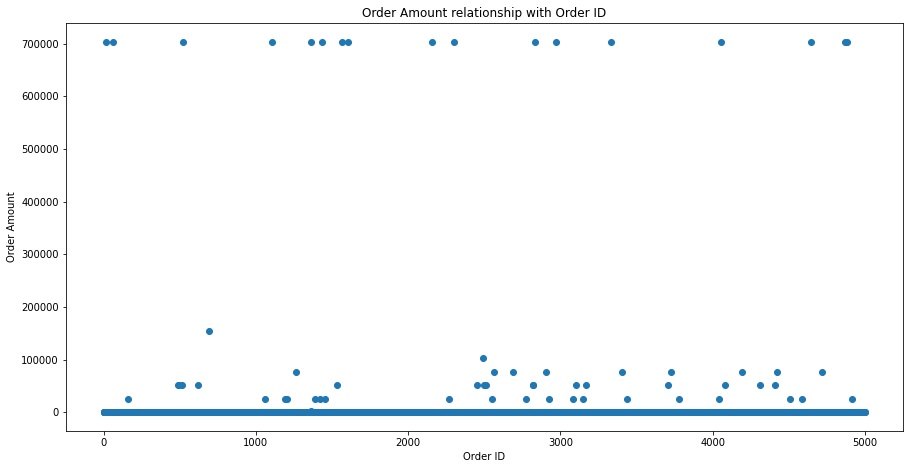

In [7]:
plt.figure(figsize=(15,7.5))
plt.scatter(df['order_id'], df['order_amount'])
plt.xlabel('Order ID')
plt.ylabel('Order Amount')
plt.title('Order Amount relationship with Order ID')

[Text(0.5, 0, 'Shop ID'),
 Text(0, 0.5, 'Order Amount'),
 Text(0.5, 1.0, 'Order Amounts for all stores')]

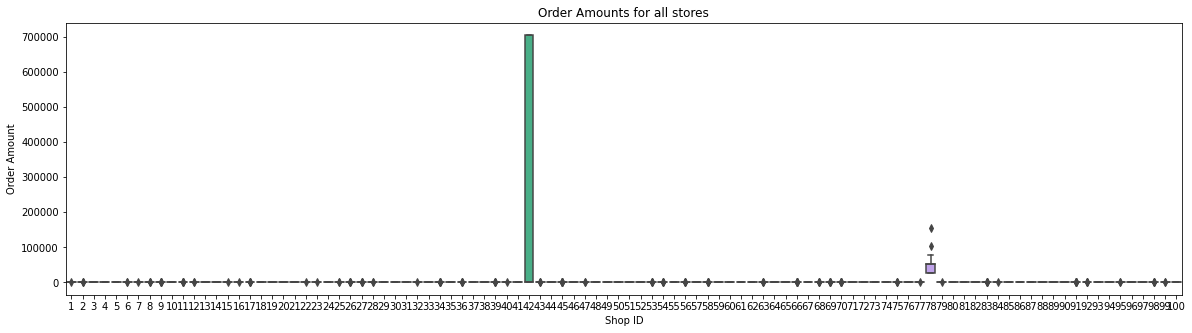

In [8]:
plt.subplots(figsize=(20, 5))
sns.boxplot(x = df['shop_id'], y = df['order_amount'], data = df).set(xlabel = 'Shop ID', ylabel = 'Order Amount', title = "Order Amounts for all stores")

## Suspicions confirmed in `order_amount`

<!-- Knowing we have 5000 rows of orders, we see that for `order_amount` in the scatter plot above that most of our points lie near 0. In addition, we only have a handful of extremely high outliers with $order\_amount > 700000$ and some more of our values stay in more of less in the $~200000$ range. -->

Above, we can see that out of our $5000$ orders, we have a few very extreme ($~700000$) and a handful of relatively extreme ($~100000$) outlying order amounts. Most of our orders actually have order amounts in the range $[90, 531]$. Knowing our min is $90$, the outliers above $order\_amount = 531$ are overpowering our bulk of lower amounts in the visualization.

We can also see that it is possible just a couple of stores (store 42 and 78) are overpowering our data with either extremely high sales, extremely high prices, or both. However, we cannot directly filter out data from two specific stores in case they are indeed selling for prices similar in comparison to others but have exceptionally high sales.

Seeing that the bulk of our values are being overpowered by just a handful of outliters, we should think about filtering out our most extreme outliters based more on the amounts themselves than specific stores.

Nevertheless, we cannot also afford to ignore nearly 10% of our total orders ... hence, we need to filter out a smaller number of extreme outliers. Based on a simple visual approach from the scatter plot, let us filter out all values of $order\_amount > 100000$.

Text(0.5, 1.0, '[Outliers Removed] Order Amount relationship with Order ID')

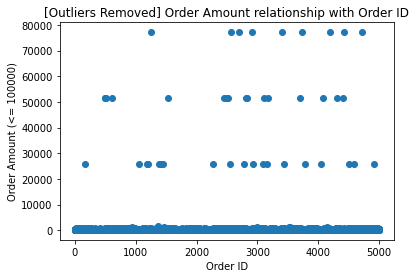

In [9]:
df_ordamt_trimmed = df[df['order_amount'] <= 100000]
plt.scatter(df_ordamt_trimmed['order_id'], df_ordamt_trimmed['order_amount'])
plt.xlabel('Order ID')
plt.ylabel('Order Amount (<= 100000)')
plt.title('[Outliers Removed] Order Amount relationship with Order ID')

In [10]:
df_ordamt_trimmed = df_ordamt_trimmed[df_ordamt_trimmed['order_amount'] <= 20000]
df_ordamt_trimmed.describe()

,order_id,shop_id,user_id,order_amount,total_items
count,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000
mean,2499.551347,49.846465,849.752279,302.580514,1.994734
std,1444.069407,29.061131,86.840313,160.804912,0.982821
min,1.000000,1.000000,700.000000,90.000000,1.000000
25%,1248.000000,24.000000,775.000000,163.000000,1.000000
50%,2497.000000,50.000000,850.000000,284.000000,2.000000
75%,3751.000000,74.000000,925.000000,387.000000,3.000000
max,5000.000000,100.000000,999.000000,1760.000000,8.000000


[Text(0.5, 0, 'Order Amount (<= 20000)'),
 Text(0.5, 1.0, 'Distribution of Order Amounts after removing outliers')]

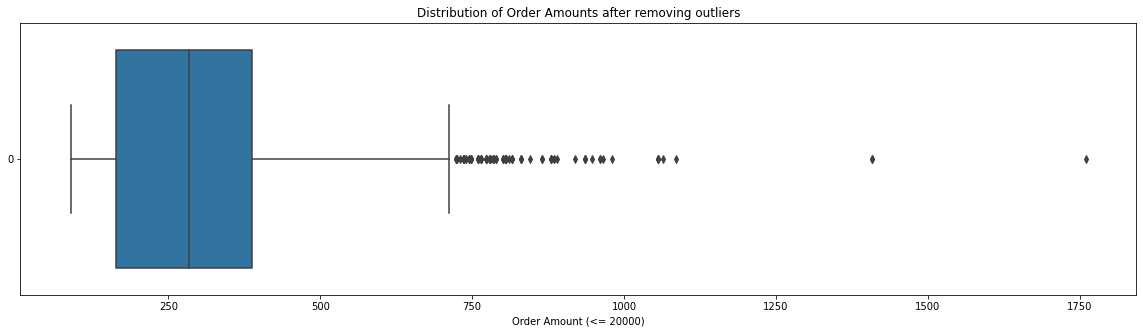

In [11]:
plt.subplots(figsize=(20, 5))
sns.boxplot(data=df_ordamt_trimmed['order_amount'], orient='horizontal').set(xlabel='Order Amount (<= 20000)', title = 'Distribution of Order Amounts after removing outliers')

## Variation of `order_amount` across stores

Now that we have some cleaner data with outliers filtered out for better understanding and usage, we can also analyze how `order_amounts`s vary across different stores.

We know originally stores 42 and 78 were overpowering the sales data from the other stores. Now we can see the performance of those stores after removing some exceptionally high outlying orders.

[Text(0.5, 0, 'Shop ID'),
 Text(0, 0.5, 'Order Amount'),
 Text(0.5, 1.0, '[Outliers Removed] Order Amounts for all stores')]

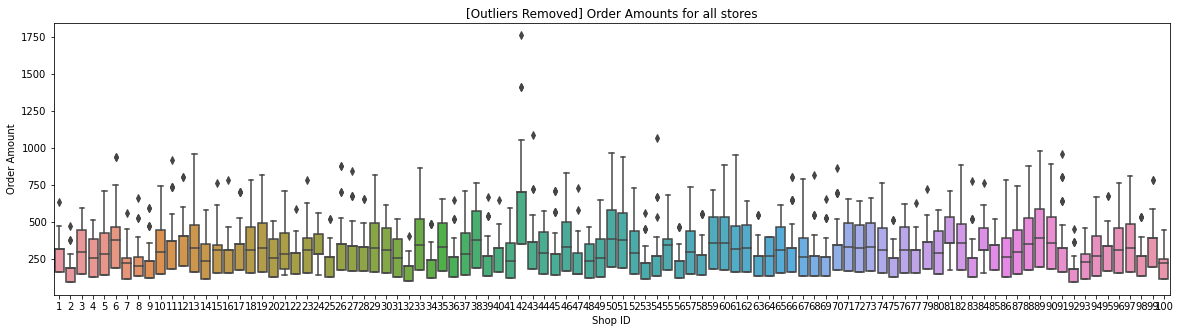

In [12]:
plt.subplots(figsize=(20, 5))
sns.boxplot(x = df_ordamt_trimmed['shop_id'], y = df_ordamt_trimmed['order_amount'], data = df_ordamt_trimmed).set(xlabel = 'Shop ID', ylabel = 'Order Amount', title = "[Outliers Removed] Order Amounts for all stores")

## Concluding analysis of `order_amount`

Through our analysis of `order_amount`, we can see that originally we had some outliers to our orders with extremely high `order_amount`s that were overpowering the mean of our total set of 5000 orders.

We could also see that two stores (42 and 78) were possibly responsible for giving us exceptionally high `order_amoun`s, however, we were not initially sure whether it was because of a high selling price or exceptionally great sales or a combination of both.

By first analyzing our orders, we see that taking the 98th percent of our orders based on their `order_amount`s and ignoring the top 2\% of sales gives us a much more realisitic $297.67 as our AOV.

We also see through comparing filtered orders to the shops that shop 42 still has orders falling within our permissable region. This means that shop 42 had sales that were both in line with other stores but also had a few exceptionally high orders. On the other hand, we see that after filtering out our top 2\% of sales, shop 78's orders are non existent. This could mean that shop 78 was exclusively charging high prices. 

But it could also be that shop 78 was selling sneakers at a reasonable price but did not have any low quantity orders. Therefore, it is necessary to also analyse `total_items` in addition to just `order_amount`.

In [13]:
print("Original AOV from direct mean: $", round(df['order_amount'].mean(), 2))
print("Percentile of order_amount filtered on $20000:", stats.percentileofscore(df['order_amount'], 20000))
print("AOV from mean after removing top 2% outliers: $", round(df[df.order_amount < df.order_amount.quantile(.98)]['order_amount'].mean(), 2))

Original AOV from direct mean: $ 3145.13
Percentile of order_amount filtered on $20000: 98.74
AOV from mean after removing top 2% outliers: $ 297.67


# Analysing `total_items`

To start off, we see how our `total_items` are distributed through our orders. We count the number of orders with certain number of `total_items`.

We note that out of $5000$ orders, only 17 orders have an outlying `total_items` value of 2000. All other orders have number of items in them ranging from 1 to 8.

We need see how our `total_items` vary with respect to different orders and different shops. We already know that shop 42 has a combination of extremely high number of items in some orders with some other orders being more in line with other shops, implying it is selling sneakers at a reasonable price.

However, we need to confirm that nature of orders for shop 78 which we cannot confidently say has reasonable selling prices for sneakers and only had bulk purchases driving up its `order_amount`s or whether it has low quantities and high selleing prices.

In [14]:
print("Total_items vs number of orders containing these many items:")
df.groupby(df.total_items)['total_items'].count()

Total_items vs number of orders containing these many items:


total_items
1       1830
2       1832
3        941
4        293
5         77
6          9
8          1
2000      17
Name: total_items, dtype: int64

[Text(0.5, 0, 'Shop ID'),
 Text(0, 0.5, 'Total Items'),
 Text(0.5, 1.0, 'Total Items in orders for all stores')]

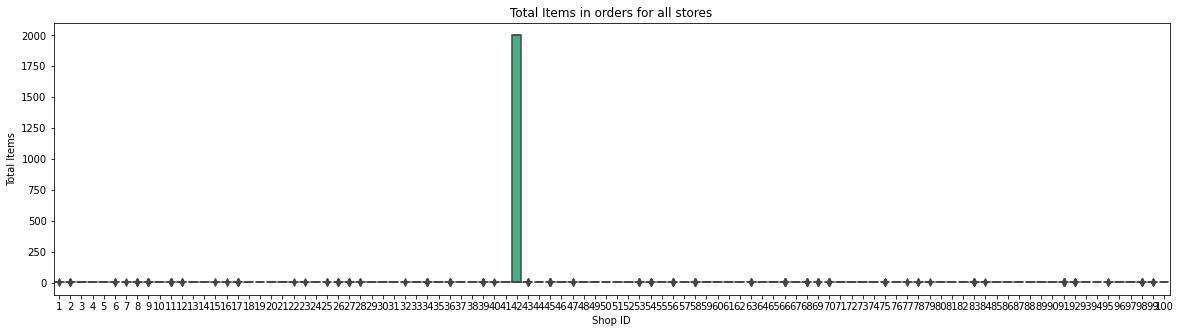

In [15]:
plt.subplots(figsize=(20, 5))
sns.boxplot(x = df['shop_id'], y = df['total_items'], data = df).set(xlabel = 'Shop ID', ylabel = 'Total Items', title = "Total Items in orders for all stores")

## Variation of `total_items` across stores

Knowing that for our specific dataset, only 17 orders have an outlying `total_items` value of 2000. All other orders have number of items in them ranging from 1 to 8.

Through our above visualtiazion, we also see that all of these outlying 17 orders containing unusually high number of items all belong to shop 42. Hence, we filter out these outlying orders to see how our remianing orders are distributed across stores.

[Text(0.5, 0, 'Shop ID'),
 Text(0, 0.5, 'Total Items'),
 Text(0.5, 1.0, '[Outliers trimmed] Total Items in orders for all stores')]

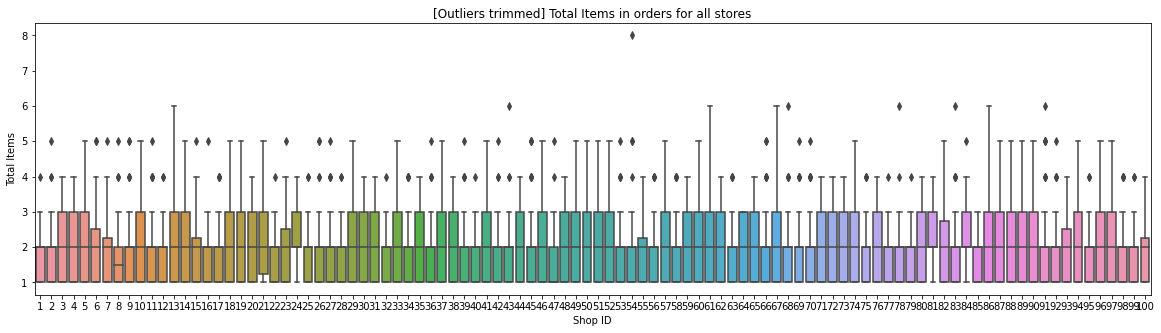

In [16]:
df_totitem_trimmed = df[df['total_items'] < 2000]
plt.subplots(figsize=(20, 5))
sns.boxplot(x = df_totitem_trimmed['shop_id'], y = df_totitem_trimmed['total_items'], data = df).set(xlabel = 'Shop ID', ylabel = 'Total Items', title = "[Outliers trimmed] Total Items in orders for all stores")


## Concluding analysis of `total_items`

Through our analysis of `total_items`, we can see that only the top 1% of our orders contain quanitities of items that are outliers but are still extreme enough to overpower our other `total_items` closer to the mean number of items per orders.

We earlier had some suspicions on sales of shops 42 and 78 since they were skewing our total dataset of orders for all of our 5000 orders to date encompassing 100 shops.

We can now say with confirmation that shop 42 has a per unit selling price that is reasonable and closer to the avg across all stores and that it has a combination of orders with quantities closer to the mean of `total_items` but also has a few orders with extremely high quanities.

However, for shop 78, Seeing that both before and after removing outliers, it records `total_items` relatively similar to other shops, we can conclude that its reason for extremely high `order_amounts` is an extremely high selling price per unit sneaker.

In [17]:
print("Average number of items/order originally", df['total_items'].mean())
print("Percentile of total_items for 2000 items/order: ", stats.percentileofscore(df['total_items'], 2000))
print("Average number of items/order after removing top 1%", round(df[df.total_items < df.total_items.quantile(.98)]['total_items'].mean(), 0))


Average number of items/order originally 8.7872
Percentile of total_items for 2000 items/order:  99.84
Average number of items/order after removing top 1% 2.0


# 1b. Metric that we should report

To do some analysis of average order value (AOV), the simple metric of taking the mean of `order_amount`s should work fine. However, we should make sure to remove some outliers from our data before calculating our metric.

Through our analysis, we realized that for our given data, removing orders in our top 2% of `order_amount`s and top 1% of `total_items` gives us data that is more representative of orders from our 100 shops.

For scalability of our model to account for higher magnitudes of orders, let us adopt a filter of removing all orders lying in the top 2% of either `order_amount`s or `total_items`. Considering the law of averages, even if we scale our number of stores and orders, our data will tend to move closer to the average.

Hence, for the time being, adopting a practise of removing the top 2% of our orders before calculating the mean AOV of `order_amount` as our reporting metrix works well.

In [18]:
df_filtered = df[(df.order_amount < df.order_amount.quantile(.98)) & (df.total_items < df.total_items.quantile(.98))]

Text(0.5, 1.0, '[Removed top 2%] Order Amount relationship with Order ID')

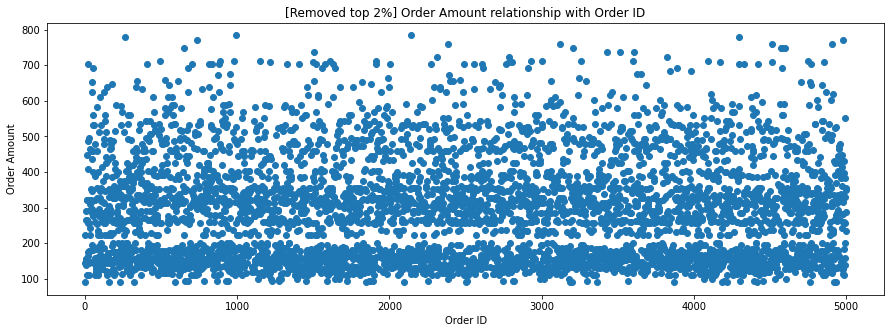

In [19]:
plt.figure(figsize=(15,5))
plt.scatter(df_filtered['order_id'], df_filtered['order_amount'])
plt.xlabel('Order ID')
plt.ylabel('Order Amount')
plt.title('[Removed top 2%] Order Amount relationship with Order ID')

[Text(0.5, 0, 'Shop ID'),
 Text(0, 0.5, 'Total Items'),
 Text(0.5, 1.0, '[Removed top 2%] Total Items in orders for all stores')]

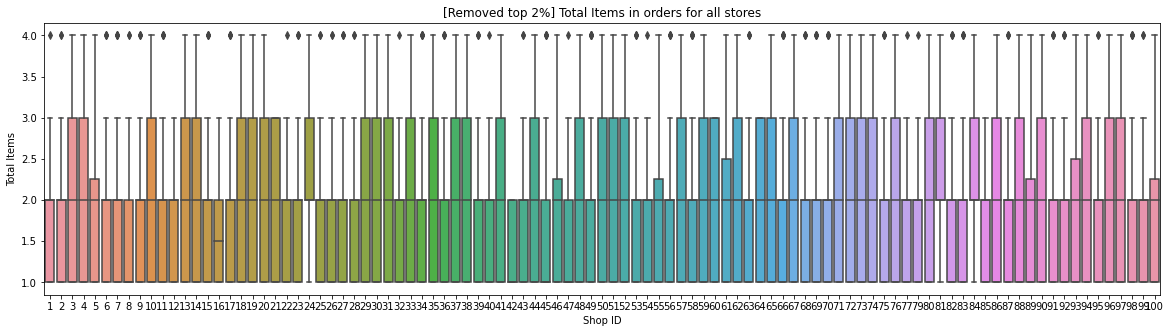

In [20]:
plt.subplots(figsize=(20, 5))
sns.boxplot(x = df_filtered['shop_id'], y = df_filtered['total_items'], data = df).set(xlabel = 'Shop ID', ylabel = 'Total Items', title = "[Removed top 2%] Total Items in orders for all stores")


# 1c. Final metric to report

Resultantly, we see above that removing that top 2\% of orders with outlying `order_amount`s and `total_items` gives us data that is much more representative of the average of 5000 orders across 100 shops.

Moreover, as explained above, it is theoretically robust for scaling up our number of shops as well as our orders to work as business experiences growth.

Finally, we see the improvement comparing our original AOV to the new AOV that we should report after filtering out outliers being $293.06.

In [21]:
print("Original AOV: $", round(df['order_amount'].mean(), 2))
print("AOV after removing top 2% of orders: $", round(df_filtered['order_amount'].mean(), 2))


Original AOV: $ 3145.13
AOV after removing top 2% of orders: $ 293.06
